<a href="https://colab.research.google.com/github/YDj-robot/Predicting-Earthquake-Damage-Makwanpur/blob/main/Predicting_Earthquake_Damage_Makwanpur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Earthquake Damage with Logistic Regression in Makwanpur District of Nepal

## Earthquake Magnitude, Damage and Impact
## Context
In April of 2015 the 7.8 magnitude Gorkha earthquake occured near the Gorkha district of Gandaki Pradesh, Nepal. Almost 9,000 lives were lost, millions of people were instantly made homeless, and $10 billion in damages––about half of Nepal's nominal GDP––were incurred. In the years since, the Nepalese government has worked intensely to help rebuild the affected districts' infrastructures. Throughout this process, the National Planning Commission, along with Kathmandu Living Labs and the Central Bureau of Statistics, has generated
## the goal
###Predicting Earthquake Damage with Logistic Regression in Makwanpur District of Nepal
1. Prepare the dataset for binary classification
2. Create a logistic regression model to predict severe damage
3. Explain model predication using odds ratio

### 1- Prepare Data

#### 1.1- Import Data

In [ ]:
#!pip install kaggle
#!pip install category_encoders

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 711.3 kB/s eta 0:00:00


In [ ]:
from google.colab import files
import os
import json

# Upload Kaggle JSON file
uploaded = files.upload()

# Set Kaggle API credentials
kaggle_json = json.loads(uploaded['kaggle.json'].decode('utf-8'))
os.environ['KAGGLE_USERNAME'] = kaggle_json['username']
os.environ['KAGGLE_KEY'] = kaggle_json['key']

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d arashnic/earthquake-magnitude-damage-and-impact

 94% 67.0M/71.1M [00:02<00:00, 34.3MB/s]
100% 71.1M/71.1M [00:02<00:00, 25.8MB/s]


In [ ]:
!unzip earthquake-magnitude-damage-and-impact.zip

Archive:  earthquake-magnitude-damage-and-impact.zip
  inflating: csv_building_damage_assessment.csv  
  inflating: csv_building_ownership_and_use.csv  
  inflating: csv_building_structure.csv  
  inflating: csv_household_demographics.csv  
  inflating: csv_household_earthquake_impact.csv  
  inflating: csv_household_resources.csv  
  inflating: csv_individual_demographics.csv  
  inflating: mapping.csv             
  inflating: ward_vdcmun_district_name_mapping.csv  


In [ ]:
def wrangle(file_path):

  # Import data
  df = pd.read_csv(file_path, index_col="building_id")

  # Select District Makwanpur: District 31
  df = df[df["district_id"] == 24]

  # droping leaky features and other unneeded columns
  drop_cols = [col
               for col in df.columns
               if "post_eq" in col
               or col in ["district_id", "vdcmun_id", "ward_id", "technical_solution_proposed"]
  ]

  # Create binary target
  df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
  df["severe_damage"] = (df["damage_grade"] > 3).astype(int)


  # Add the old target feature to drop columns list
  drop_cols.append("damage_grade")

  # Drop columns
  df.drop(columns=drop_cols, inplace=True)

  return df

In [ ]:
df_building_structure = wrangle("csv_building_structure.csv")
df_building_structure.head()

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,severe_damage
building_id,,,,,,,,,,,,,,,,,,,,,
240101000011,1,40,324,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,0,0,0,0,0
240101000021,2,30,382,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,...,0,0,0,0,0,0,0,0,0,1
240101000031,1,13,405,10,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,0,0,0,0,1
240101000041,2,25,328,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Not attached,...,0,0,0,0,0,0,0,0,0,1
240101000051,2,15,405,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,...,0,0,0,0,0,0,0,0,0,1


#### 1.2- Explore Data

In [ ]:
df_building_structure["severe_damage"].value_counts()

1    52833
0    45186
Name: severe_damage, dtype: int64

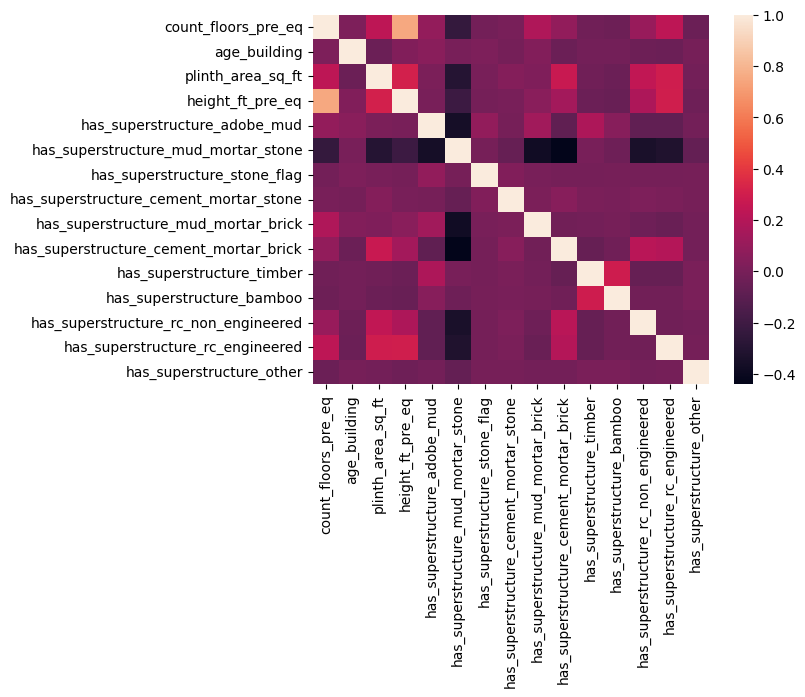

In [ ]:
# make sure there's no issue with multicollinearity in our dataset.
# Create correlation matrix
correlation = df_building_structure.select_dtypes("number").drop(columns="severe_damage").corr()
# Plot heatmap of `correlation`
sns.heatmap(correlation);

In [ ]:
# Drop Multicollinearity
print(df_building_structure["severe_damage"].corr(df_building_structure["count_floors_pre_eq"]))
print(df_building_structure["severe_damage"].corr(df_building_structure["height_ft_pre_eq"]))

# choosing The first one because it is less correlated with the target value
df_building_structure.drop(columns="count_floors_pre_eq", inplace=True)

-0.039660950851764874
-0.15984250802434435


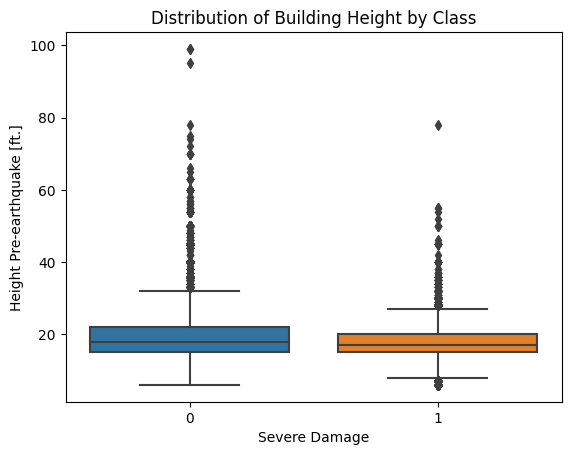

In [ ]:
# Create boxplot
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df_building_structure)
# Label axes
plt.xlabel("Severe Damage")
plt.ylabel("Height Pre-earthquake [ft.]")
plt.title("Distribution of Building Height by Class");

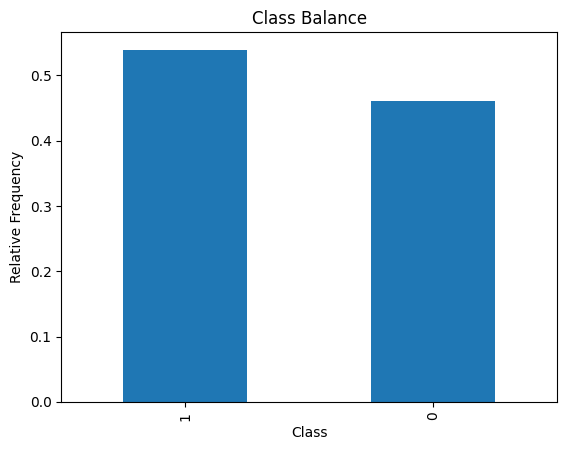

In [ ]:
# Plot value counts of `"severe_damage"`
df_building_structure["severe_damage"].value_counts(normalize=True).plot(kind="bar",
                                                      xlabel="Class",
                                                      ylabel="Relative Frequency",
                                                      title="Class Balance");


In [ ]:
majority_class_prop, minority_class_prop = df_building_structure["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.5390077433966884 0.4609922566033116


In [ ]:
# What about the foundation type feature!
foundation_pivot = pd.pivot_table(
    df_building_structure, index="foundation_type", values="severe_damage", aggfunc=np.mean
).sort_values(by="severe_damage")

foundation_pivot

,severe_damage
foundation_type,
RC,0.010949
Bamboo/Timber,0.267281
Cement-Stone/Brick,0.272224
Other,0.314741
Mud mortar-Stone/Brick,0.600677


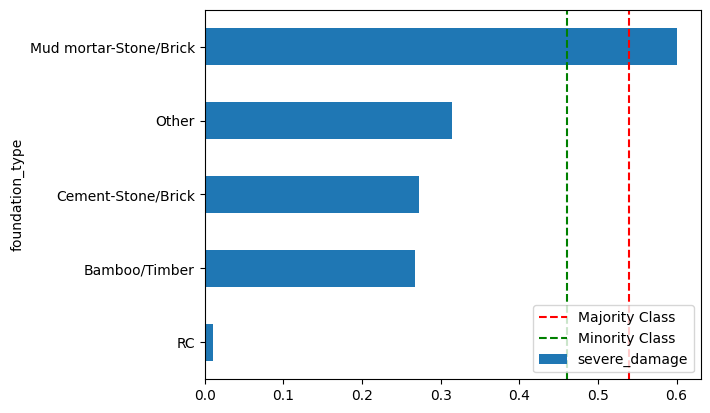

In [ ]:
foundation_pivot.plot(kind="barh", legend=None)
plt.axvline(majority_class_prop, linestyle="--", color="red", label="Majority Class")
plt.axvline(minority_class_prop, linestyle="--", color="green", label="Minority Class")
plt.legend(loc="lower right");

In [ ]:
# Is there are any high- or low-cardinality categorical features in the dataset?
# Check for high- and low-cardinality categorical features
df_building_structure.select_dtypes("object").nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
dtype: int64

#### 1.3- Split Data

In [ ]:
target = "severe_damage"
X = df_building_structure.drop(columns=target)
y = df_building_structure[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state=42)

### 2- Build Model

#### 2.1 Baseline

In [ ]:
acc_baseline = y.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.54


#### 2.2 Logistic Regression

In [ ]:
# Build model
model = make_pipeline( OneHotEncoder(use_cat_names=True),
                       LogisticRegression(max_iter=1000))
# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

#### 2.3 Evaluate: Accuracy Score

In [ ]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))
print("Baseline Accuracy:", round(acc_baseline, 2))

Training Accuracy: 0.66
Test Accuracy: 0.66
Baseline Accuracy: 0.54


### 3- Communicate Results

In [ ]:
y_train_pred_proba = model.predict_proba(X_train)

# Create a DataFrame
column_names = ['0', '1']
df_y_train_pred_proba = pd.DataFrame(y_train_pred_proba, columns=column_names)
df_y_train_pred_proba = (df_y_train_pred_proba * 100).round(2)
df_y_train_pred_proba.head(7)

,0,1
0,92.80,7.20
1,35.53,64.47
2,38.34,61.66
3,39.64,60.36
4,67.88,32.12
5,94.00,6.00
6,44.63,55.37


In [ ]:
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]

##### Features that are associated with severe damage

In [ ]:
odds_ratios = pd.Series(np.exp(importances), index=features).sort_values(ascending=False)
odds_ratios.head()

has_superstructure_mud_mortar_stone       2.007959
foundation_type_Mud mortar-Stone/Brick    1.771751
foundation_type_Cement-Stone/Brick        1.499198
has_superstructure_stone_flag             1.455401
roof_type_Bamboo/Timber-Light roof        1.365186
dtype: float64

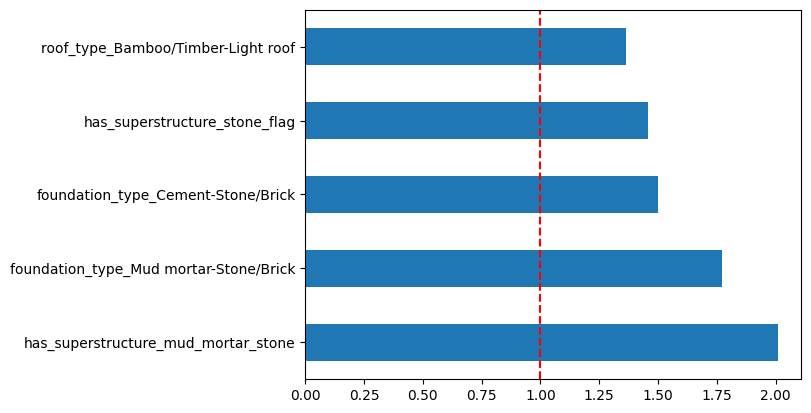

In [ ]:
odds_ratios.head().plot(kind="barh")
plt.axvline(1, linestyle="--", color="red");

**Comment:** When the superstructure is mud mortar stone, the chance of the building having severe damage increases two times or (200%).

##### Features that are associated with decrease in damage

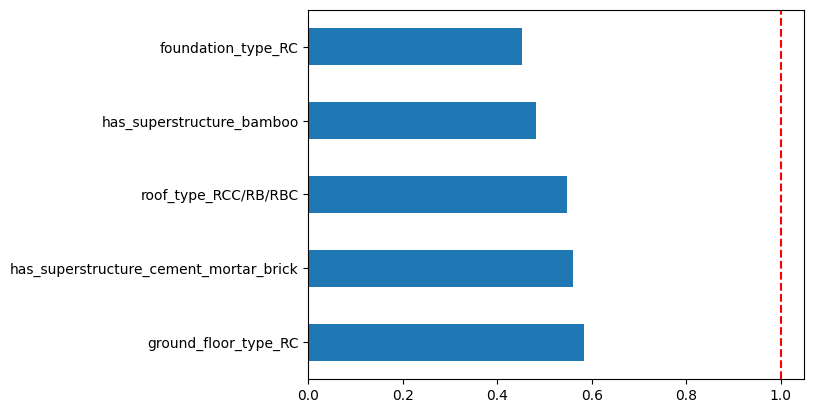

In [ ]:
odds_ratios.tail().plot(kind="barh")
plt.axvline(1, linestyle="--", color="red");

In [ ]:
foundation_type_RC = odds_ratios["foundation_type_RC"]
print(round(( 1 - foundation_type_RC ) * 100, 2),"%")

54.82 %


**Comment**:
*   Buildings with foundation type RC were 54.82% less likely to suffer severe damage
*   Generally speaking, having reinforced concrete (RC) greatly reduces the likelihood of a building suffering severe damage.